In [1]:
import pandas as pd
import numpy as np
import tensorflow

print(tensorflow.__version__)

2.7.0


In [21]:
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Lambda, Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import mse, binary_crossentropy
import tensorflow.keras.backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [3]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()

In [4]:
df = pd.read_csv('data/creditcard.csv', sep=',', index_col=None)
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))
df.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,1.641931,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,-0.350151,0
284803,1.641952,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,-0.254117,0
284804,1.641974,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,-0.081839,0
284805,1.641974,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,-0.313249,0
284806,1.642058,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,0.514355,0


In [6]:
anomalies = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

anomalies.shape, normal.shape

((492, 31), (284315, 31))

In [7]:
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])

In [8]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis=1),
                                                   df['Class'], test_size=0.2, random_state=42)

print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

(16320, 29) train samples
(4080, 29) test samples


In [9]:
def sampling(args):
    z_mean, z_log_var = args
    batch = tensorflow.keras.backend.shape(z_mean)[0]
    dim = tensorflow.keras.backend.int_shape(z_mean)[1]
    
    epsilon = tensorflow.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + epsilon*tensorflow.keras.backend.exp(0.5*z_log_var)

In [10]:
orginal_dim = x_train.shape[1]
print(orginal_dim)

29


In [11]:
input_shape = (orginal_dim,)
intermediate_dim = 12
batch_size = 32
latent_dim = 2
epochs = 20

In [14]:
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name = 'z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [15]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 29)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 12)           360         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 2)            26          ['dense[0][0]']                  
                                                                                                  
 z_log_var (Dense)              (None, 2)            26          ['dense[0][0]']                  
                                                                                            

In [16]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(orginal_dim, activation='sigmoid')(x)

In [17]:
decoder = Model(latent_inputs, outputs, name = 'decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 12)                36        
                                                                 
 dense_2 (Dense)             (None, 29)                377       
                                                                 
Total params: 413
Trainable params: 413
Non-trainable params: 0
_________________________________________________________________


In [18]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name = 'vae_mlp')

In [19]:
reconstruction_loss = mse(inputs, outputs)

In [22]:
reconstruction_loss *= orginal_dim
k1_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
k1_loss = K.sum(k1_loss, axis=-1)
k1_loss *= -0.5

In [23]:
vae_loss = K.mean(reconstruction_loss + k1_loss)
vae.add_loss(vae_loss)

In [24]:
vae.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 29)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          412         ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 29)           413         ['encoder[0][2]']                
                                                                                            

In [25]:
history = vae.fit(x_train, x_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 shuffle=True,
                 validation_data=(x_test, x_test),
                 callbacks = [TensorBoard(log_dir='../logs/variationalautoencoder')])

Epoch 1/20
510/510 [==============================] - 2s 2ms/step - loss: 299.8521 - accuracy: 0.0990 - val_loss: 56.7319 - val_accuracy: 0.1525
Epoch 2/20
510/510 [==============================] - 1s 2ms/step - loss: 50.0250 - accuracy: 0.1259 - val_loss: 54.4289 - val_accuracy: 0.1186
Epoch 3/20
510/510 [==============================] - 1s 2ms/step - loss: 49.4186 - accuracy: 0.1055 - val_loss: 53.3804 - val_accuracy: 0.1047
Epoch 4/20
510/510 [==============================] - 1s 2ms/step - loss: 49.2096 - accuracy: 0.0990 - val_loss: 52.6366 - val_accuracy: 0.1022
Epoch 5/20
510/510 [==============================] - 1s 2ms/step - loss: 49.0608 - accuracy: 0.0974 - val_loss: 52.1742 - val_accuracy: 0.0929
Epoch 6/20
510/510 [==============================] - 1s 1ms/step - loss: 48.9962 - accuracy: 0.0917 - val_loss: 51.9028 - val_accuracy: 0.1105
Epoch 7/20
510/510 [==============================] - 1s 1ms/step - loss: 48.9496 - accuracy: 0.1014 - val_loss: 51.7489 - val_accuracy

In [26]:
score = vae.evaluate(x_test, x_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

128/128 [==============================] - 0s 1ms/step - loss: 50.9684 - accuracy: 0.2529
Test loss: 50.96842956542969
Test accuracy: 0.25294119119644165


In [27]:
threshold = 10.00
y_pred = vae.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label = []
error = []

for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)

In [28]:
roc_auc_score(y_test, y_label)

0.9003090689903477

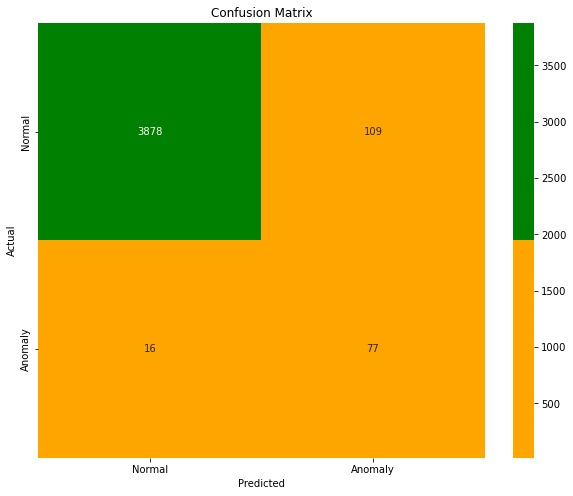

In [29]:
viz = Visualization()
viz.draw_confusion_matrix(y_test, y_label)

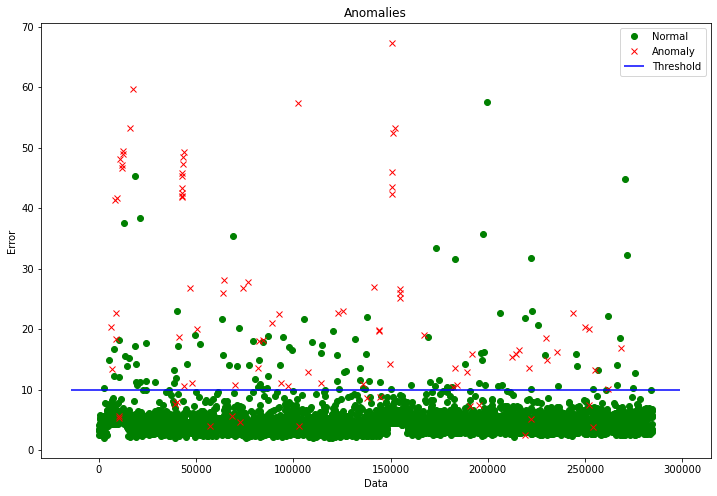

In [30]:
viz.draw_anomaly(y_test, error, threshold)